In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from typing import Tuple, List
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy
import numba as nb
import requests
import sys

sys.path.insert(1, "./umap")
warnings.filterwarnings('always')

def visualize(x, y, axis):
    colors = cm.rainbow(np.linspace(0, 1, max(y) - min(y) + 1))
    for sample_index in range(len(x)):
        sample = x[sample_index]
        label = y[sample_index]
        axis.scatter(sample[0], sample[1], color=colors[label], s=10)

def visualize_loss(function):
    X = np.arange(0.1, 0.9, 0.1)
    Y = np.arange(0.1, 0.9, 0.1)
    X = np.exp(-X ** 2) + 1e-8
    Y = 1 / ((1 + Y ** 2) + 1e-8) + 1e-8
    X, Y = np.meshgrid(X, Y)
    Z = function(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(azim=30)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def evaluate_visualizations(
    min_neighbors: int,
    max_neighbors: int,
    low_dimension_factory,
    show_cross_entropy: bool = False,
    one_run: bool = False):
    def evaluate_umap(axis, neighbors: List[int]):
        print(f'Running UMAP for neighbors count: {neighbors}')
        axis.set_title(f'Neighbors: {neighbors}')
        response = low_dimension_factory(neighbors)
        visualize(response[0], labels, axis)
        y = MinMaxScaler().fit_transform(response[0])
        return response
    figure, axes = plt.subplots(2, 2, figsize=(12, 12))
    evaluate_umap(axes[0, 0], [min_neighbors])
    if one_run:
        return []
    evaluate_umap(axes[0, 1], [max_neighbors])
    response = evaluate_umap(axes[1, 0], [min_neighbors, max_neighbors])
    if len(response) > 1:
        axes[1, 1].plot(response[1], label="Weighted Cross Entropy")
        axes[1, 1].legend()
    if len(response) > 2 and show_cross_entropy:
        axes[1, 1].plot(response[2], label="Cross Entropy")
        axes[1, 1].legend()
    return response[1] if len(response) > 1 else None

def visualize_digits():
    _, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 3))
    for ax, image, label in zip(axes, digits, labels):
        ax.set_axis_off()
        matrix = image.reshape(8, 8)
        ax.imshow(matrix, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("Label: %i" % label)

dataset = load_digits()
labels = dataset.target #[0:200]
digits = dataset.data #[0:200]
digits.shape

(1797, 64)

## Parameters

In [2]:
distances = euclidean_distances(digits, digits)
MIN_NEIGHBORS = 5
MAX_NEIGHBORS = 10
FULL_MIN_NEIGHBORS = int(len(digits) / 2)
FULL_MAX_NEIGHBORS = len(digits)
MIN_DIST = 1.0
ITERATION_LIMIT = 150

## L1. Fuzzy Cross Entropy

/data/umap/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


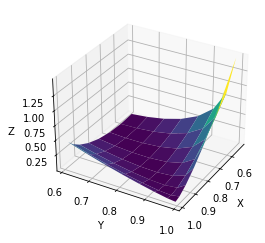

In [3]:
from algorithm import umap, GradientOptimizer, Adam, CrossEntropyLoss
visualize_loss(lambda P, Q: P * np.log(P / Q) + (1 - P) * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[1]: loss 15998866.63813432
[50]: loss 68412.7711417712
[100]: loss 51221.80074017356
[150]: loss 42034.742049401604
Running UMAP for neighbors count: [1797]
[1]: loss 4934012.9879488535
[50]: loss 200554.20438169345
[100]: loss 170800.95480276068
[150]: loss 168027.43729531614
Running UMAP for neighbors count: [10, 1797]
[1]: loss 5378346.584650688
[50]: loss 135200.82555090296
[100]: loss 113976.49622337348
[150]: loss 107884.13058546597
CPU times: user 11min 24s, sys: 30.9 s, total: 11min 55s
Wall time: 6min 27s


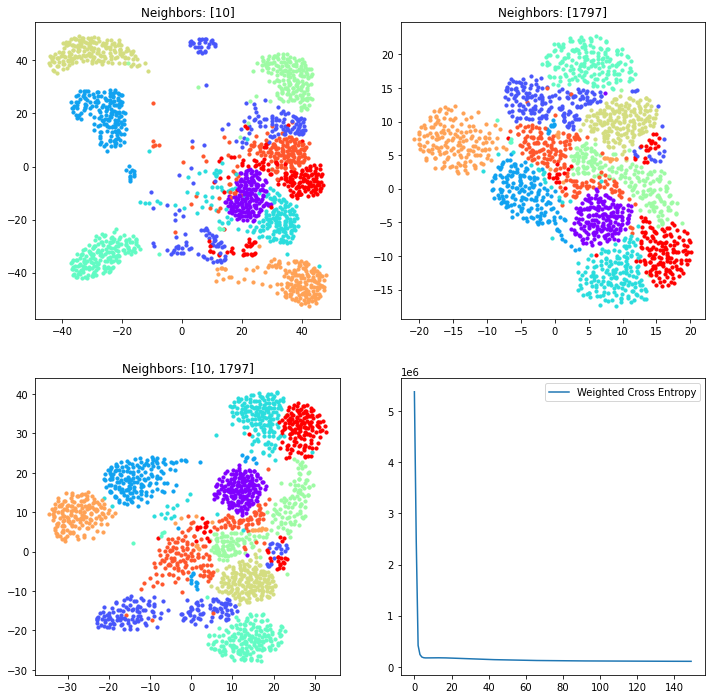

In [4]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss())))

## L2. Symmetric Fuzzy Cross Entropy

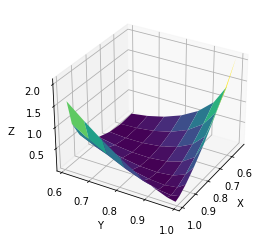

In [5]:
from algorithm import SymmetricLoss
visualize_loss(lambda P, Q: (P - Q) * np.log((P * (1 - Q)) / (Q * (1 - P))))

Running UMAP for neighbors count: [10]
[1]: loss 43949211.805278614
[50]: loss 127042.39929529856
[100]: loss 116605.37625458634
[150]: loss 109973.27178490759
Running UMAP for neighbors count: [1797]
[1]: loss 12870764.528984988
[50]: loss 174113.08479781338
[100]: loss 130821.87918458306
[150]: loss 115832.8864367473
Running UMAP for neighbors count: [10, 1797]
[1]: loss 14888384.781126643
[50]: loss 129942.99354085504
[100]: loss 99006.81869792908
[150]: loss 85870.23096157213
CPU times: user 10min 36s, sys: 34.3 s, total: 11min 10s
Wall time: 4min 59s


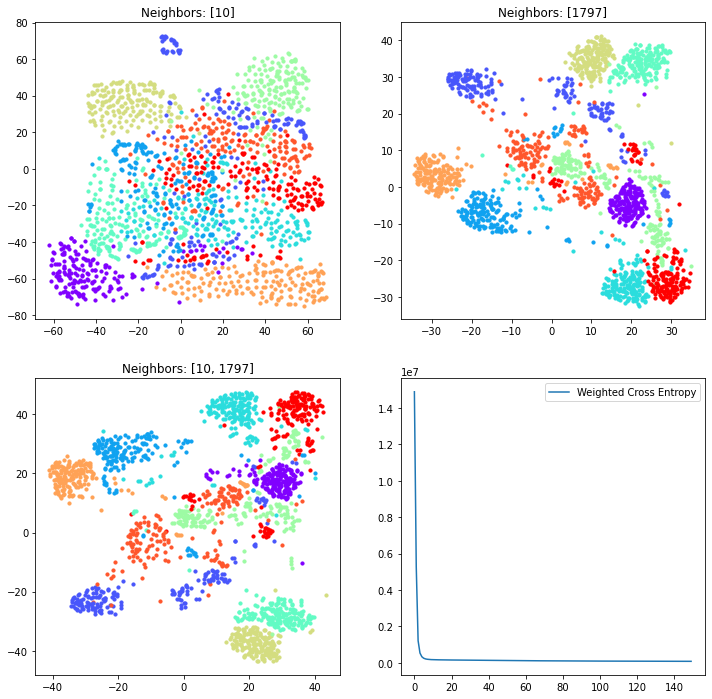

In [6]:
%%time
sl = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=SymmetricLoss())))

## L3. Intuitionistic Fuzzy Cross Entropy

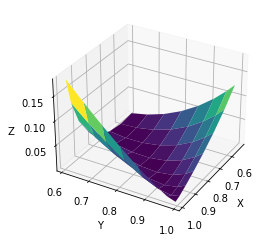

In [7]:
from algorithm import IntuitionisticLoss
visualize_loss(lambda P, Q: P * np.log(P / (0.5*P + 0.5*Q)) + (1 - P)*np.log((1 - P) / (1 - 0.5*(P + Q))))

Running UMAP for neighbors count: [10]
[1]: loss 1164090.7092757844
[50]: loss 15867.48465945853
[100]: loss 15447.328192927413
[150]: loss 15221.752316420716
Running UMAP for neighbors count: [1797]
[1]: loss 521153.2669505283
[50]: loss 108842.99891820879
[100]: loss 108038.0223341142
[150]: loss 107531.31895183424
Running UMAP for neighbors count: [10, 1797]
[1]: loss 533144.9522827875
[50]: loss 69998.13559397635
[100]: loss 69522.80047551342
[150]: loss 69232.05328928173
CPU times: user 10min 50s, sys: 40.1 s, total: 11min 30s
Wall time: 4min 55s


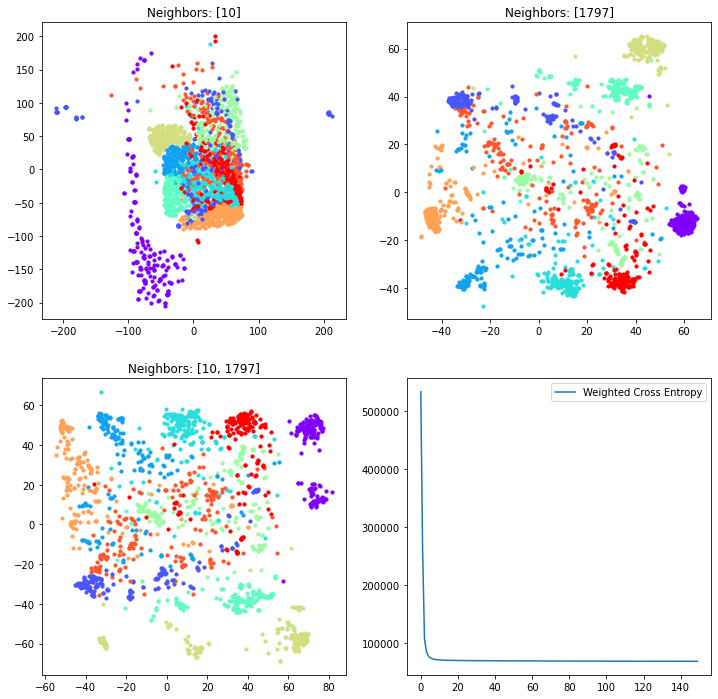

In [8]:
%%time
il = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=0.1 * MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=IntuitionisticLoss())))

## L4. Weighted Fuzzy Cross Entropy

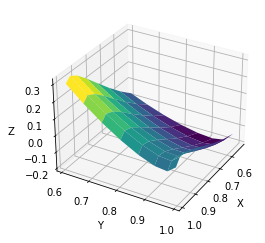

In [9]:
visualize_loss(lambda P, Q: P * np.log(P / Q) + 0.05 * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]
[1]: loss 24840.000941467282
[50]: loss 1824.6445892382615
[100]: loss 1449.2573107122548
[150]: loss 1442.907133063915
Running UMAP for neighbors count: [1797]
[1]: loss 37018.49191370222
[50]: loss 22156.81225326755
[100]: loss 21643.340588226638
[150]: loss 21640.01188376951
Running UMAP for neighbors count: [10, 1797]
[1]: loss 24000.30627956334
[50]: loss 12919.006764448877
[100]: loss 12647.525468244645
[150]: loss 12645.513012557118
CPU times: user 11min 17s, sys: 26.9 s, total: 11min 44s
Wall time: 5min 15s


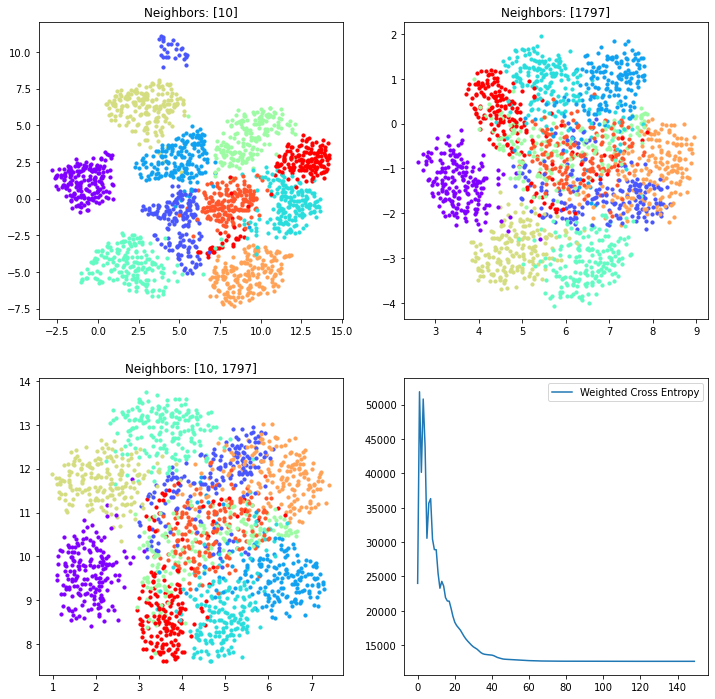

In [10]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss(reduce_repulsion=True))))

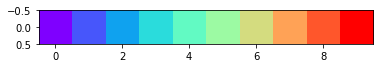

In [11]:
plt.imshow([cm.rainbow(np.linspace(0, 1, max(labels) - min(labels) + 1))])